Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/14/batchnorm_torch.ipynb

# Batch normalization

We implement a batchnorm layer from scratch and add to LeNet CNN.

Code based on sec 7.5 of http://d2l.ai/chapter_convolutional-modern/batch-norm.html



In [2]:
import jax
import jax.numpy as jnp  # JAX NumPy
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np  # Ordinary NumPy

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers
try:
    import tensorflow_datasets as tfds  # TFDS for MNIST
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds  # TFDS for MNIST

import random
import os
import time

!mkdir figures                          # for saving plots

mkdir: cannot create directory ‘figures’: File exists


# Implementation from scratch

For fully connected layers, we take the average along minibatch samples for each dimension independently. For 2d convolutional layers, we take the average along minibatch samples, and along horizontal and vertical locations, for each channel (feature dimension) independently.

When training, we update the estimate of the mean and variance using a moving average. When testing (doing inference), we use the pre-computed values.

In [3]:
def batch_norm(X, train, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `train` to determine whether the current mode is training
    # mode or prediction mode
    if not train:
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean.value) / jnp.sqrt(moving_var.value + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)

        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / jnp.sqrt(var + eps)

        # Update the mean and variance using moving average
        moving_mean.value = momentum * moving_mean.value + (1.0 - momentum) * mean
        moving_var.value = momentum * moving_var.value + (1.0 - momentum) * var

    Y = gamma * X_hat + beta  # Scale and shift
    return Y

# Wrap the batch norm function in a layer

In [4]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer.
    num_features: int

    # `num_dims`: 2 for a fully-connected layer and 4 for a convolutional layer
    num_dims: int

    # Use `train` to determine whether the current mode is training
    # mode or prediction mode
    train: bool

    @nn.compact
    def __call__(self, X):
        if self.num_dims == 2:
            shape = (1, self.num_features)
        else:
            shape = (1, 1, 1, self.num_features)

        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        gamma = self.param("gamma", jax.nn.initializers.ones, shape)
        beta = self.param("beta", jax.nn.initializers.zeros, shape)

        # The variables that are not model parameters are initialized to 0 and 1
        moving_mean = self.variable("batch_stats", "moving_mean", jnp.zeros, shape)
        moving_var = self.variable("batch_stats", "moving_var", jnp.ones, shape)

        # Save the updated `moving_mean` and `moving_var`
        Y = batch_norm(X, self.train, gamma, beta, moving_mean, moving_var, eps=1e-5, momentum=0.9)

        return Y

# Applying batch norm to LeNet

We add BN layers after some of the convolutions and fully connected layers,
but before the activation functions.

In [5]:
# NOTE: The LeNet in batchnorm_torch.ipynb uses max pooling instead of average
#       pooling. Here I'm switching to average pooling since that's what the
#       original paper did.
# NOTE: I adapted the following code from notebooks-d2l/lenet_jax.ipynb.


class LeNetBN(nn.Module):
    @nn.compact
    def __call__(self, x, *, train):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding=[(2, 2), (2, 2)])(x)
        x = BatchNorm(6, num_dims=4, train=train)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = nn.Conv(features=16, kernel_size=(5, 5), padding=[(0, 0), (0, 0)])(x)
        x = BatchNorm(16, num_dims=4, train=train)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = BatchNorm(120, num_dims=2, train=train)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.Dense(features=84)(x)
        x = BatchNorm(84, num_dims=2, train=train)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.Dense(features=10)(x)
        return x

# Train the model

We train the model using the same code as in the [standard LeNet colab](https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks-d2l/lenet_jax.ipynb). The only difference from the previous colab is the larger learning rate (which is possible because BN stabilizes training).

In [6]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder("fashion_mnist")
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))
    train_ds["image"] = jnp.float32(train_ds["image"]) / 255.0
    test_ds["image"] = jnp.float32(test_ds["image"]) / 255.0
    return train_ds, test_ds

## Plotting

In [7]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

## Training Function

In [9]:
def compute_metrics(*, logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

We create a subclass of `train_state.TrainState` store the auxilliary variables (i.e. `gamma` and `beta`) required by `BatchNorm`.

In [10]:
from typing import Any


class BatchNormTrainState(train_state.TrainState):
    batch_stats: Any = None

Since the same training procedure needs to be applied on two different networks (i.e. `LeNetBN` and `LeNetBNFlax`), we define a `train_procedure_builder` helper function to create separate procedures for these two networks. Note that we cannot simply pass the model class to the training functions because we are using `@jax.jit` and `nn.Module` is not a valid JAX type.

In [11]:
def train_procedure_builder(Net):
    def create_train_state(rng, learning_rate):
        """Creates initial `BatchNormTrainState`."""
        variables = Net().init(rng, jnp.ones([1, 28, 28, 1]), train=True)
        batch_stats, params = variables.pop("params")
        tx = optax.sgd(learning_rate)
        return BatchNormTrainState.create(apply_fn=Net().apply, params=params, tx=tx, batch_stats=batch_stats)

    @jax.jit
    def train_step(state, batch):
        """Train for a single step."""

        def loss_fn(params):
            variables = {"params": params, **state.batch_stats}
            logits, new_batch_stats = Net().apply(variables, batch["image"], mutable=["batch_stats"], train=True)
            one_hot = jax.nn.one_hot(batch["label"], num_classes=10)
            loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
            return loss, (new_batch_stats, logits)

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (_, (new_batch_stats, logits)), grads = grad_fn(state.params)

        state = state.apply_gradients(grads=grads)
        metrics = compute_metrics(logits=logits, labels=batch["label"])
        new_state = state.replace(batch_stats=new_batch_stats)
        return new_state, metrics

    @jax.jit
    def eval_step(state, batch):
        variables = {"params": state.params, **state.batch_stats}
        logits = Net().apply(variables, batch["image"], train=False)
        return compute_metrics(logits=logits, labels=batch["label"])

    def train_epoch(state, train_ds, batch_size, epoch, rng, animator):
        """Train for a single epoch."""
        train_ds_size = len(train_ds["image"])
        steps_per_epoch = train_ds_size // batch_size

        perms = jax.random.permutation(rng, train_ds_size)
        perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, batch_size))
        batch_metrics = []
        for perm in perms:
            batch = {k: v[perm, ...] for k, v in train_ds.items()}
            state, metrics = train_step(state, batch)
            batch_metrics.append(metrics)

        # compute mean of metrics across each batch in epoch.
        batch_metrics_np = jax.device_get(batch_metrics)
        epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

        animator.add(epoch, (epoch_metrics_np["loss"], epoch_metrics_np["accuracy"], None))
        print(
            "train epoch: %d, loss: %.4f, accuracy: %.2f"
            % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
        )

        return state

    def eval_model(state, test_ds):
        metrics = eval_step(state, test_ds)
        metrics = jax.device_get(metrics)
        summary = jax.tree_map(lambda x: x.item(), metrics)
        return summary["loss"], summary["accuracy"]

    def train(train_ds, test_ds, num_epochs, batch_size, learning_rate):
        rng = jax.random.PRNGKey(42)
        rng, init_rng = jax.random.split(rng)
        state = create_train_state(init_rng, learning_rate)
        del init_rng  # Must not be used anymore.

        animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
        for epoch in range(1, num_epochs + 1):
            # Use a separate PRNG key to permute image data during shuffling
            rng, input_rng = jax.random.split(rng)
            # Run an optimization step over a training batch
            state = train_epoch(state, train_ds, batch_size, epoch, input_rng, animator)
            # Evaluate on the train and test set after each training epoch
            train_loss, train_accuracy = eval_model(state, train_ds)
            test_loss, test_accuracy = eval_model(state, test_ds)
            animator.add(epoch, (None, None, test_accuracy))
            print(f"loss {train_loss:.3f}, train acc {train_accuracy:.3f}, " f"test acc {test_accuracy:.3f}")

        return state

    return train

In [12]:
learning_rate = 1.0
num_epochs = 10
batch_size = 256

train_ds, test_ds = get_datasets()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


loss 0.348, train acc 0.872, test acc 0.858


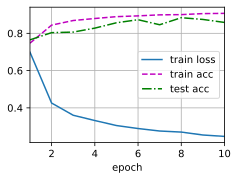

In [13]:
train = train_procedure_builder(LeNetBN)
state = train(train_ds, test_ds, num_epochs, batch_size, learning_rate)

# Examine learned parameters

In [14]:
state.params["BatchNorm_0"]["gamma"].reshape((-1,)), state.params["BatchNorm_0"]["beta"].reshape((-1,))

(DeviceArray([2.1345313, 4.4614625, 4.3005934, 1.9170749, 2.963077 ,
              2.1844447], dtype=float32),
 DeviceArray([-0.01249033,  1.5363886 , -1.2060173 , -0.9933149 ,
              -1.2563591 , -0.881196  ], dtype=float32))

# Use Flax's BatchNorm layer

The built-in layer is much faster than our Python code, since it is implemented in C++. Note that instead of specifying ndims=2 for fully connected layer (batch x features) and ndims=4 for convolutional later (batch x channels x height x width), we simply use `BatchNorm` and take advantage of JAX's shape inference feature.

In [15]:
class LeNetBNFlax(nn.Module):
    @nn.compact
    def __call__(self, x, *, train):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding=[(2, 2), (2, 2)])(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = nn.Conv(features=16, kernel_size=(5, 5), padding=[(0, 0), (0, 0)])(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.Dense(features=84)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)  # <---
        x = nn.sigmoid(x)
        x = nn.Dense(features=10)(x)
        return x

## Learning Curve

loss 0.241, train acc 0.911, test acc 0.894


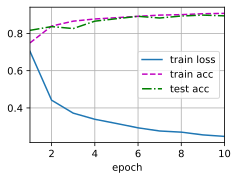

In [16]:
train = train_procedure_builder(LeNetBNFlax)
state = train(train_ds, test_ds, num_epochs, batch_size, learning_rate)

## Examine learned parameters

In [17]:
state.params["BatchNorm_0"]["scale"].reshape((-1,)), state.params["BatchNorm_0"]["bias"].reshape((-1,))

(DeviceArray([2.9159937, 2.7028058, 2.9027553, 3.6763802, 2.8250368,
              3.3413725], dtype=float32),
 DeviceArray([ 1.104101  ,  1.1390349 , -0.95292634, -2.4381783 ,
              -1.6936823 , -2.6453147 ], dtype=float32))